# Python packages required to run the mode

In [1]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
from scipy.signal import find_peaks, peak_prominences, peak_widths, savgol_filter
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool

import shutil
import os



# Read measured reflectance data (and epsilon)

Please read the measured spectra and if needed average it.
Measured Reflectance should be between 0-1.

If the viewing angle of the sample is not normal, please update the viewing_angle variable in the code block below

The code block below reads the individual spectra of the sample, averages it and plots the same.

The sample hawaii spectra for three spots are provided in the github folder.

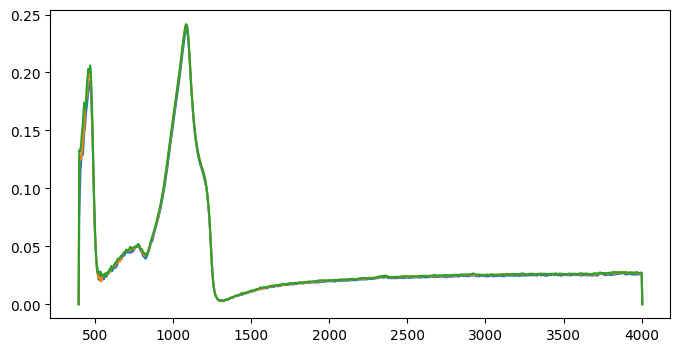

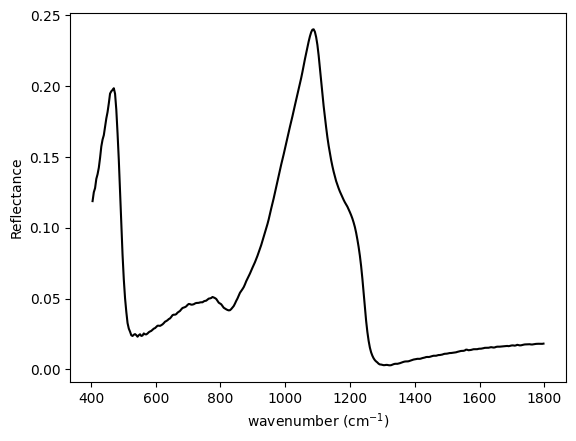

In [2]:
# read data
# data=xlsread('082420_pure_pellet_PARSEC_data'); #original spectra used in the code 

spot1 = np.loadtxt('hawaii_glass_spot1.CSV', delimiter=',')
spot2 = np.loadtxt('hawaii_glass_spot2.CSV', delimiter=',')
spot3 = np.loadtxt('hawaii_glass_spot3.CSV', delimiter=',')
viewing_angle = 0

plt.figure(figsize=(8,4))
plt.plot(spot1[:,0], spot1[:,1]/100, label='spot1')
plt.plot(spot2[:,0], spot2[:,1]/100, label='spot2')
plt.plot(spot3[:,0], spot3[:,1]/100, label='spot3')
plt.show()


# data = spot1.copy()
data = np.average([spot1,spot2,spot3], axis=0)

np.savetxt("hawaii_single_crystal_average.txt",data)

v=data[:,0]
R=data[:,1]/100

#cut out data with wavenumbers < 350 cm-1 and wavenumbers >1600 cm-1
R = R[(v>400) & (v<1800)][1:]
v = v[(v>400) & (v<1800)][1:]


plt.plot(v, R, 'k', label="measured R")
plt.xlabel('wavenumber (cm${^{-1}}$)') 
plt.ylabel("Reflectance")
plt.show()






# Numerical model  - Dispersion and Fresnel

function fresnel_sbu: fresnel model for non-normal incidence which returns modeled reflectance\
function dispersion_model: dispersion_model which returns n and k\
function calculate_rnk: calculate r, n, k using fresnel_sbu and dispersion_model functions

No change is necessary in the code block below for running new sample spectra

In [3]:
def fresnel_sbu(n,k, viewing_angle): #theta = viewing_angledeg
    u1 = np.square(n)-np.square(k)-np.square(np.sin(viewing_angle*math.pi/180))
    u2 = np.sqrt(np.square(u1) + (4*np.multiply(np.square(n),np.square(k))))
    u = np.sqrt((u1+u2)/2)

    v = np.sqrt((-u1 + u2)/2)


    R_par_num = np.square(np.cos(viewing_angle*math.pi/180)-u)+ np.square(v)
    R_par_denom = np.square(np.cos(viewing_angle*math.pi/180)+u)+ np.square(v)
    R_par = np.divide(R_par_num,R_par_denom)

    R_perp_num = np.square(((np.square(n)-np.square(k))*np.cos(viewing_angle*math.pi/180))-u) + np.square((2*np.cos(viewing_angle*math.pi/180)*np.multiply(n,k))-v)
    R_perp_denom = np.square(((np.square(n)-np.square(k))*np.cos(viewing_angle*math.pi/180))+u) + np.square((2*np.cos(viewing_angle*math.pi/180)*np.multiply(n,k))+v)
    R_perp = np.divide(R_perp_num,R_perp_denom)

    R_sbu = (R_perp+R_par)/2

    return R_sbu


def dispersion_model(nu,gamm,fourpr,epsil,v):
# dispersion_model: Spitzer and Kleinman dispersion model
# v: frequency list
# gamm: damping parameter
# fourpr: bandwidth parameter
# epsil: bulk dialectric constant

    # make v be Mx1
    v = v[:,None]

    # make nu, fourpr, gamm be 1xN 
    nu = nu[:,None].T
    fourpr = fourpr[:,None].T 
    gamm = gamm[:,None].T 

    v = np.tile(v,(1,len(nu)))
    nu = np.tile(nu,(len(v),1))
    fourpr = np.tile(fourpr,(len(v),1))
    gamm = np.tile(gamm,(len(v),1))

    a = np.square(nu)-np.square(v)
    denom = np.square(a) + np.square(nu * gamm * v)
    alpha = np.divide((fourpr*np.square(nu)*a),denom)
    bet = np.divide(((fourpr/2) * np.square(nu) * gamm * nu * v),denom)
    theta = epsil + np.sum(alpha,axis=1)
    phi = np.sum(bet,axis=1)
    a2 = np.sqrt(np.square(theta) + (4*np.square(phi)))
    n = np.sqrt((theta+a2)/2)
    k = np.divide(phi,n)

    return n, k

def calculate_rnk(coef,v, viewing_angle):
# disp_model_wrap: wrapper for dispersion model

    N = int((len(coef)-1)/3)
#     if isinstance(N, int): 
#         print('ERROR: disp_model_wrap_sbu: bad length for coefficient list!')
    
    nu = coef[0:N]
    gamm = coef[N:N+N]
    fourpr = coef[N+N:N+N+N]
    epsil = coef[N+N+N]

    n,k = dispersion_model(nu,gamm,fourpr,epsil,v)
    r = fresnel_sbu(n,k, viewing_angle)

    return r,n,k




# calculate initital parameters using genetic algorithm

## gene space and parameters for pygad

The code block below plots the measured reflectance and its second derivative in two different plots. Bokeh is used to plot in this particular codeblock as it helps us to extract the exact wavenumber position and its index of the boundaries (end-points) of 6 spectral ranges

In [4]:

output_notebook()

df = {'wavelength':v,
     'reflectance':R,
     'sav_gol_R':savgol_filter(R, 21,3),
     'sav_gol_R_diff':savgol_filter(R,21,3, deriv=2)}

source = ColumnDataSource(df)
p = figure(width=500, height=300, title="measured reflectance", x_axis_label="wavenumber", y_axis_label="reflectance")
p.line('wavelength','reflectance', source = source, legend_label="R_measured", line_width=1, color='black')
p.line('wavelength','sav_gol_R', source = source, legend_label="R_smooth", line_width=2, color='red')

p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('v','@wavelength{0.000}'),
    ('R', '@reflectance'),
    ("index", "$index")
], 
    formatters={
        'v': 'printf',
        'R' : 'printf',
    }))

show(p)



p = figure(width=500, height=300, title="Smoothed Reflectance 1st derivative", x_axis_label="wavenumber", y_axis_label="reflectance")
p.line('wavelength','sav_gol_R_diff', source = source, legend_label="R_smooth_diff", line_width=1, color='red')


p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('v','@wavelength{0.000}'),
    ('R', '@reflectance'),
    ("index", "$index")
], 
    formatters={
        'v': 'printf',
        'R' : 'printf',
    }))

show(p)

R_smoothed = savgol_filter(R, 21,3) 



Loading BokehJS ...

The range values for R1 to R6 in the spectral_range variable is extracted using the bokeh plot above. Please move-over the spectral plot to see the exact regions of boundaries of spectral ranges used in this model.

In [5]:
# spectra_range = {'R1': range(33), 'R2': range(32,108), 'R3':range(107, 226), 'R4':range(225, len(v))}

spectra_range = {'R1': range(25), 'R2': range(38,111), 'R3':range(110, 164), 'R4':range(164, 190), 'R5':range(190, 223), 'R6': range(225, len(v))}
                

# Functions for Genetic Algorithm routine

function fitness_func: calculates the fitness value between measured and modelled spectra. The function returns a fitness value in the range of 0-100. Higher the fitness value better is the fitting.

function chisq: calculates the chi-sq value between the measured and the modelled spectra. Lower the chi-sq value better is the fitting

function ga_optical_constants: Take gene_space as input and returns the ga_instance which has the information for the best fit solutions. In our study, we wrote a user defined parent_selection_func which takes all fitness value of all the parents in each GA run and sorts the fitness value from highest to lowest and selects the parents for which the difference in neighbouring oscillator frequencies (osci_diff) for all oscillators for that parent is > 10 cm-1. This parent_selection_func therefore allows us to avoid the parents whose oscillators are grouped together to a close frequencies. 

function func_lsq_R: is used in the curve_fit function in the next code block. This function acts as a objective function in the non-linear least square routine "curve_fit"

The only change that can be done in the codeblock below is varying the value for the if condition "if np.all(np.abs(osci_diff) > 10):" from 10 to a higher value or lower value depending on the nature of the spectra being studied. Otherwise, the rest of the code in the codeblock is untouched. 




In [10]:
def fitness_func(ga_instance, solution, solution_idx):
    global v
    global R_smoothed
    
    r, n, k = calculate_rnk(solution, v, viewing_angle)
    
    fitness = (1 - chisq(r, R_smoothed)) * 100 # calculating euclidean distance
    
    return fitness

def chisq(modelled, measured):
    return np.round(np.sum(np.square(modelled-measured)/measured),3)

        
def ga_optical_constants(gene_space): 
    def on_generation_progress(ga):
#         print("Generation", ga.generations_completed)
#         print("Generation shape", ga.population.shape)
#         print(ga.population)
        pbar.update(1)
            

    def parent_selection_func(fitness, num_parents, ga_instance):
        # Sorting the fitness values in descending order and getting the indices
        fitness_sorted = np.argsort(fitness)[::-1]

        oscillators_num = int((ga_instance.population.shape[1] - 1) / 3)

        parents = np.empty((num_parents, ga_instance.population.shape[1]))
        
        parent_num = 0
        for fs in fitness_sorted:
            osci_diff = np.ediff1d(ga_instance.population[fs, :oscillators_num])
            
            if parent_num < num_parents:
                if np.all(np.abs(osci_diff) > 10):
                    parents[parent_num, :] = ga_instance.population[fs, :].copy()
                    parent_num += 1
            else:
                break

        # Ensure that the indices of the selected parents are returned as a NumPy ndarray
        selected_parents_indices = np.array(fitness_sorted[:num_parents])

        return parents, selected_parents_indices

            
    num_generations=10000
    sol_per_pop=100
    num_parents_mating=10
    crossover_probability = 0.15
    mutation_percent_genes=(3,2)

    
    with tqdm.tqdm(total=num_generations) as pbar:
        ga_instance = pygad.GA(fitness_func=fitness_func,
                               num_generations=num_generations,
                               sol_per_pop=sol_per_pop,
                               num_genes=len(gene_space),
                               num_parents_mating=num_parents_mating,
                               gene_space = gene_space,
                               gene_type=float,
#                                parent_selection_type='sss',
                              parent_selection_type=parent_selection_func,
                               crossover_type='two_points', 
                               crossover_probability = crossover_probability,
                               mutation_type='adaptive', 
                              mutation_percent_genes=mutation_percent_genes,
                              save_best_solutions=True,
                              save_solutions=True,
                              suppress_warnings=True,
                              allow_duplicate_genes=False,
                               stop_criteria="saturate_100",
                              on_generation=on_generation_progress)

        ga_instance.run() 

    return ga_instance

def func_lsq_R(v, *ga_oscillation_parameters):
# disp_model_wrap: wrapper for dispersion model

    ga_oscillation_parameters = np.array(ga_oscillation_parameters)

    N = int((len(ga_oscillation_parameters)-1)/3)

    nu = ga_oscillation_parameters[0:N]
    gamm = ga_oscillation_parameters[N:N+N]
    fourpr = ga_oscillation_parameters[N+N:N+N+N]
    epsil = ga_oscillation_parameters[N+N+N]

    n,k = dispersion_model(nu,gamm,fourpr,epsil,v)
    r = fresnel_sbu(n,k, viewing_angle)

    return r


## run Genetic Algorithm

It is the final part of the algorithm which first runs the GA routine and then passes the GA found oscillators to the non-linear least square routine "curve_fit". The algorithm starts with assuming two oscillators in the entire spectral range. GA runs for this assumption and finds those oscillators and its parameters. These parameters are then passed to "curve_fit" routine to optimize their values. This modelled spectra is then inspected for its chi_sq value for each spectral range and for where the regions chi_sq are not achieved, new oscillator are assigned to add to those spectral regions and the GA-LSQ routine repeats.  This approach runs iteratively until the chi-sq value for all the spectral regions are reached or the total number of oscillators allowed for the spectra is achieved. 

The inputs that can be altered for the new samples are:

Maximum number of oscillators allowed per spectral range (R1 to R6):
max_num_oscillators_R1,max_num_oscillators_R2, max_num_oscillators_R3, max_num_oscillators_R4, max_num_oscillators_R5, max_num_oscillators_R6 

Chi square val to be achieved for each spectral range R1 to R6:
The values can be adjusted in the if statement for 
chi_sq_val_R1, chi_sq_val_R2,chi_sq_val_R3,chi_sq_val_R4,chi_sq_val_R5,chi_sq_val_R6


The codeblock below saves the results for all runs in three different folders 'best_solution_fitness', 'optical_constants', 'oscillation_params'. 

  9%|▊         | 856/10000 [02:16<24:18,  6.27it/s]


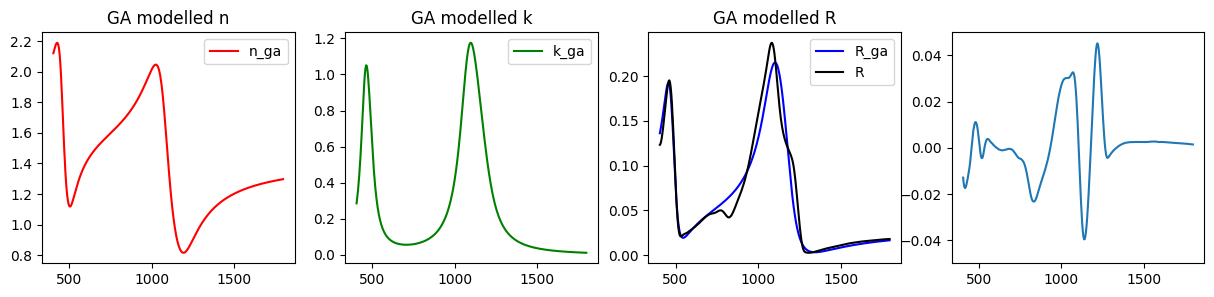

455.57497207452104	1075.9785808115353	0.14697927925249865	0.12073166120250467	0.5523790908216673	0.46620601617930446	1.9762729300503303
Fitness value of the best solution = 18.100000000000005
Best fitness value reached after 756 generations.
Chi-square goodness of overall fitness is  0.819
Chi-square goodness of R1 fitness is  0.022
Chi-square goodness of R2 fitness is  0.102
Chi-square goodness of R3 fitness is  0.211
Chi-square goodness of R4 fitness is  0.095
Chi-square goodness of R5 fitness is  0.312
Chi-square goodness of R6 fitness is  0.084


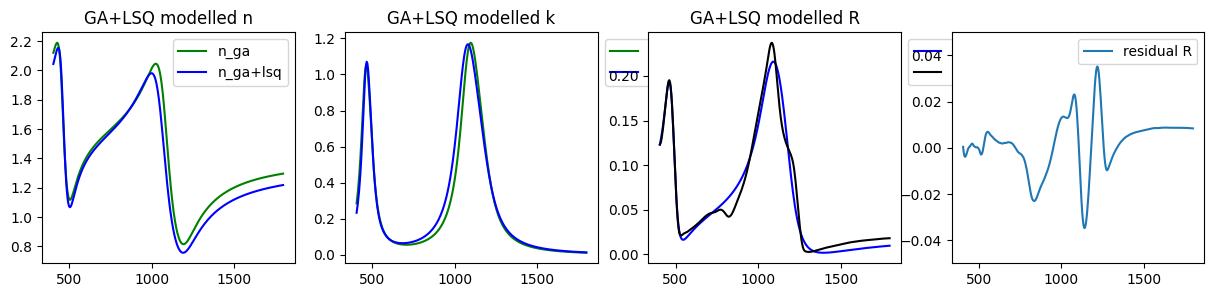

Chi-square goodness of fitness is  1.185
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.104
Chi-square goodness of R3 fitness is  0.162
Chi-square goodness of R4 fitness is  0.047
Chi-square goodness of R5 fitness is  0.185
Chi-square goodness of R6 fitness is  0.684


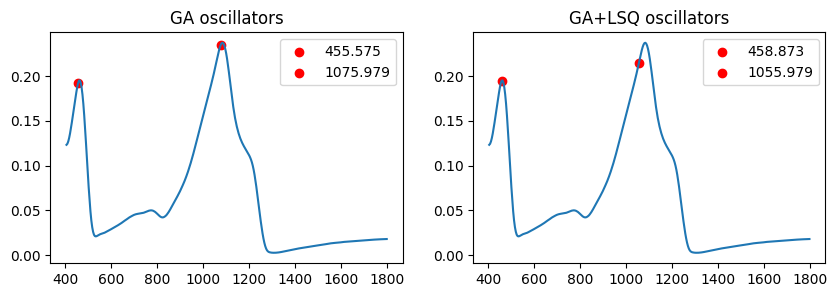

 23%|██▎       | 2293/10000 [21:00<1:10:35,  1.82it/s]


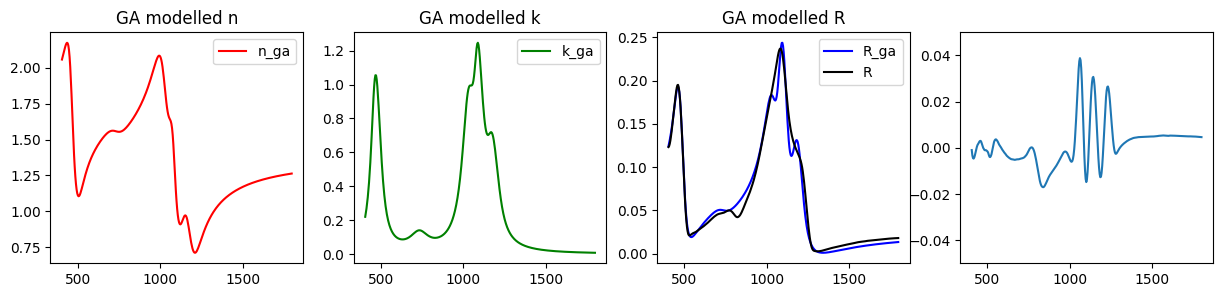

460.64905424140596	733.6603324484745	1023.6386809429432	1080.7597749069791	1167.2079543451798	0.13107145754450555	0.18272550800925114	0.08810468767219048	0.04854498906408056	0.06687377300297337	0.4916843295139668	0.055293948105701984	0.27322661495145795	0.10777020224850875	0.05758104823099064	1.8741850930985433
Fitness value of the best solution = 43.50000000000001
Best fitness value reached after 2193 generations.
Chi-square goodness of overall fitness is  0.565
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.056
Chi-square goodness of R3 fitness is  0.083
Chi-square goodness of R4 fitness is  0.062
Chi-square goodness of R5 fitness is  0.116
Chi-square goodness of R6 fitness is  0.25


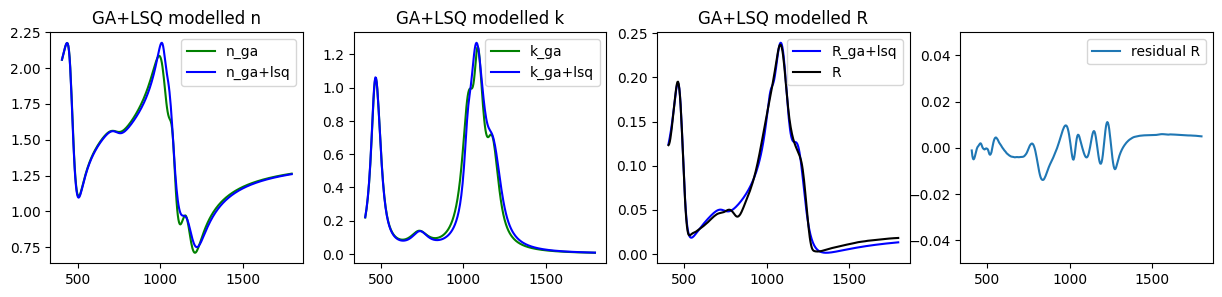

Chi-square goodness of fitness is  0.492
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.037
Chi-square goodness of R3 fitness is  0.05
Chi-square goodness of R4 fitness is  0.002
Chi-square goodness of R5 fitness is  0.016
Chi-square goodness of R6 fitness is  0.376


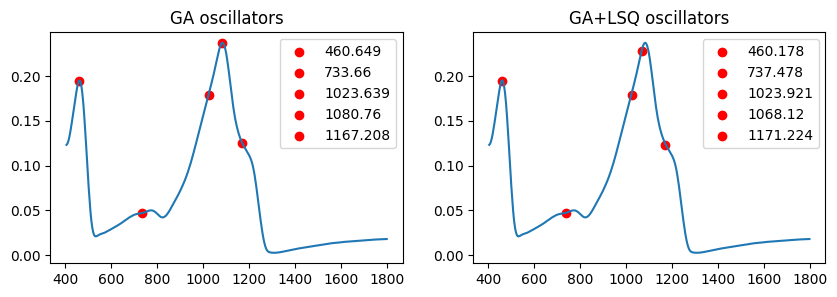

  9%|▉         | 935/10000 [04:47<46:28,  3.25it/s]  


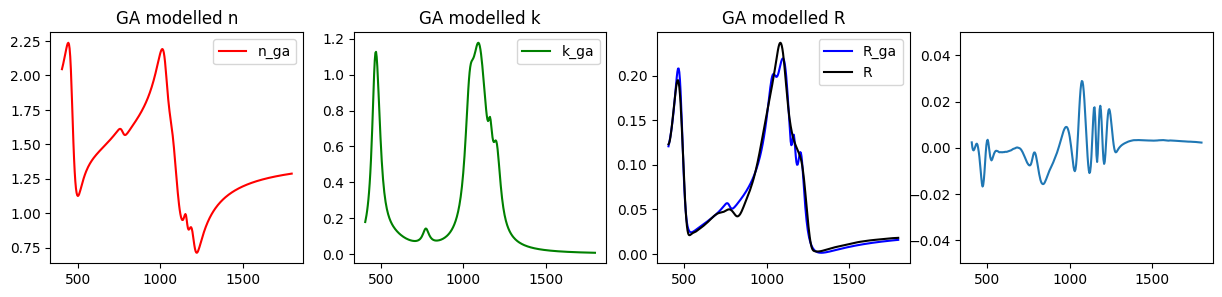

462.42091573601954	564.2465476696548	772.1458970225118	966.969429688048	1033.635649229869	1084.3045059957692	1159.083013317817	1196.252245288394	0.10475241867583196	0.48320882696030476	0.06097098496183606	1.0827598208492724	0.06350089666774394	0.08390633550625082	0.02395874892058658	0.03887831094841032	0.41768482599704004	0.10523645611278587	0.016824870162962968	0.00014989609506810275	0.17561725649828275	0.21598081550640713	0.010894599006399996	0.021816914282644317	1.938929575793359
Fitness value of the best solution = 69.30000000000001
Best fitness value reached after 835 generations.
Chi-square goodness of overall fitness is  0.307
Chi-square goodness of R1 fitness is  0.008
Chi-square goodness of R2 fitness is  0.042
Chi-square goodness of R3 fitness is  0.066
Chi-square goodness of R4 fitness is  0.03
Chi-square goodness of R5 fitness is  0.05
Chi-square goodness of R6 fitness is  0.111


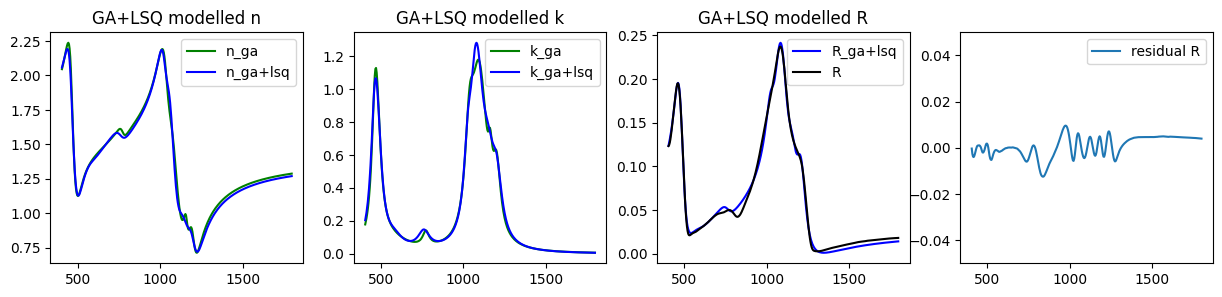

Chi-square goodness of fitness is  0.328
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.024
Chi-square goodness of R3 fitness is  0.042
Chi-square goodness of R4 fitness is  0.002
Chi-square goodness of R5 fitness is  0.006
Chi-square goodness of R6 fitness is  0.248


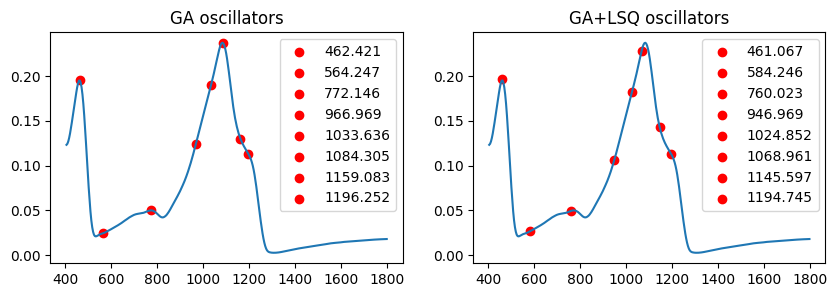

 10%|█         | 1018/10000 [06:49<1:00:08,  2.49it/s]


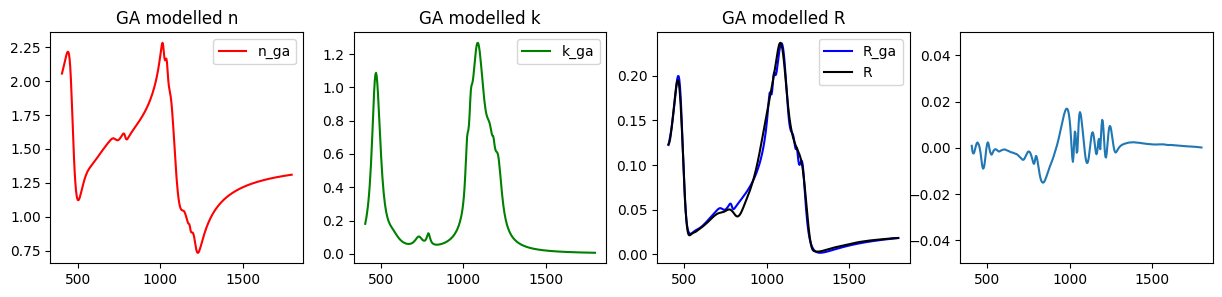

462.69231018891594	573.985427569287	729.3720219703962	787.7899844062839	923.9557278614627	1020.8657644915351	1043.508377014297	1075.2539093902844	1156.1187616684942	1180.565074970049	1206.5432729958068	0.11608081169600726	0.17260195964662706	0.08057527260443798	0.03249617924283421	1.372525706778515	0.024568138640845616	0.02203060622567854	0.0747782340786336	0.05801455426616542	0.012832849297316207	0.03645044279473586	0.4556917554420876	0.025789601423267916	0.01643890367571932	0.007598468500888744	0.0018183379108347442	0.032844989410586	0.026608254667060294	0.2915082996035989	0.04190424094553813	0.0018564565747181128	0.016371177579938	1.9919601946463708
Fitness value of the best solution = 82.60000000000001
Best fitness value reached after 918 generations.
Chi-square goodness of overall fitness is  0.174
Chi-square goodness of R1 fitness is  0.003
Chi-square goodness of R2 fitness is  0.037
Chi-square goodness of R3 fitness is  0.075
Chi-square goodness of R4 fitness is  0.007
Chi-squar

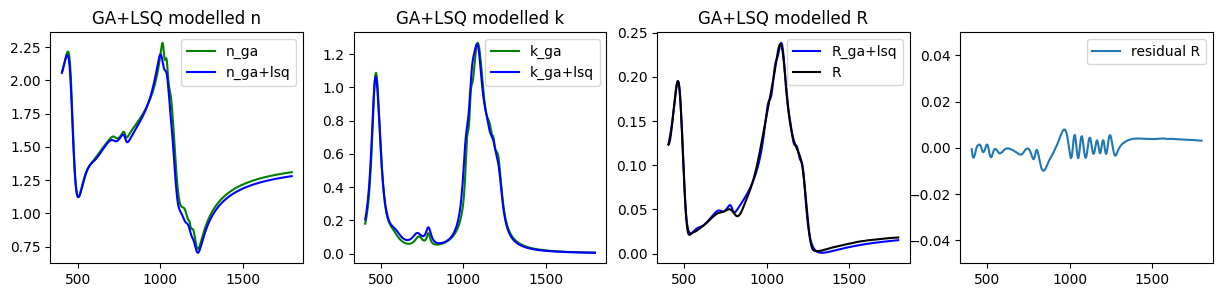

Chi-square goodness of fitness is  0.218
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.013
Chi-square goodness of R3 fitness is  0.027
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.004
Chi-square goodness of R6 fitness is  0.171


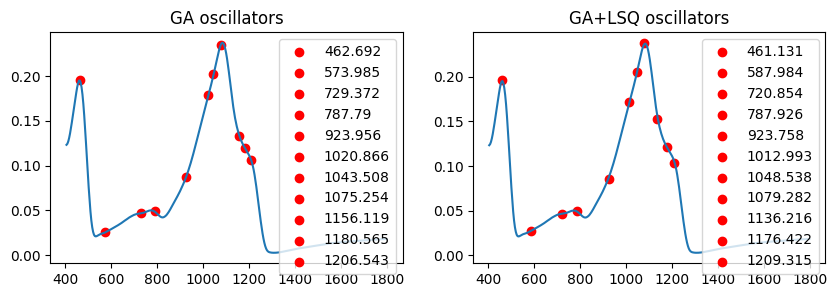

 12%|█▏        | 1184/10000 [12:52<1:35:54,  1.53it/s]  


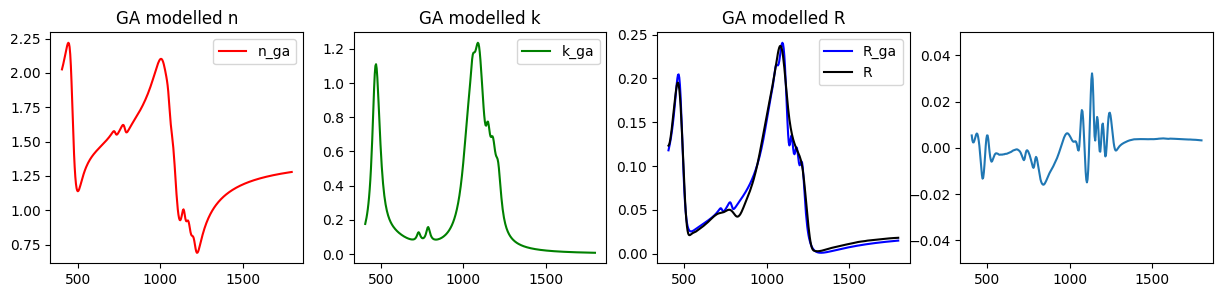

463.082691808257	561.8534473394028	572.2908709224815	728.1996976579009	785.6351739204736	871.7728122385371	922.6001088989084	1030.8503545969438	1053.4881707329787	1085.2286267274098	1146.1512446636502	1175.446124393719	1206.667887175086	0.10277737447044388	0.5780086482338467	0.5153104135805073	0.03643885379942624	0.037048218833467095	1.8083722965605775	1.7139201066839107	0.09068877584597557	0.034435519151743366	0.05275621565725386	0.02678416476049117	0.03307599891524493	0.03171265606155593	0.3973355741462561	0.061565872312336234	0.06869827592095157	0.006198848826828307	0.010549036408982193	0.0008903468070855514	0.0030257874986376887	0.24564091781943342	0.03541059475832897	0.10110805070929585	0.014803036283727922	0.01837556668271234	0.011852833704155907	1.9101388834538575
Fitness value of the best solution = 65.2
Best fitness value reached after 1084 generations.
Chi-square goodness of overall fitness is  0.348
Chi-square goodness of R1 fitness is  0.006
Chi-square goodness of R2 fitnes

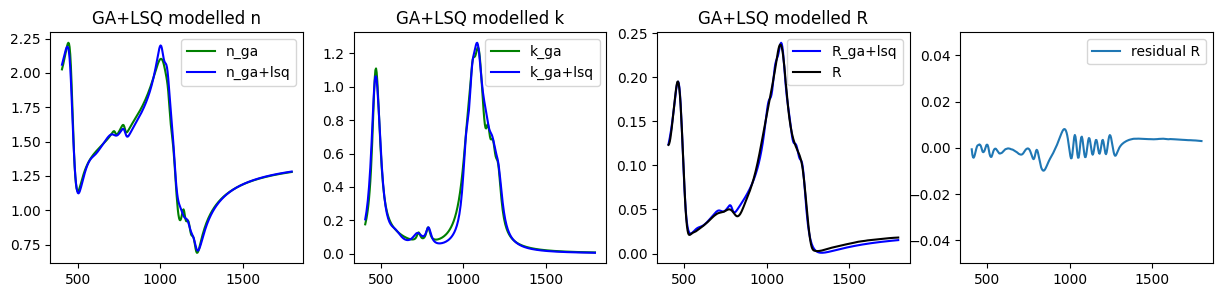

Chi-square goodness of fitness is  0.212
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.013
Chi-square goodness of R3 fitness is  0.027
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.004
Chi-square goodness of R6 fitness is  0.165


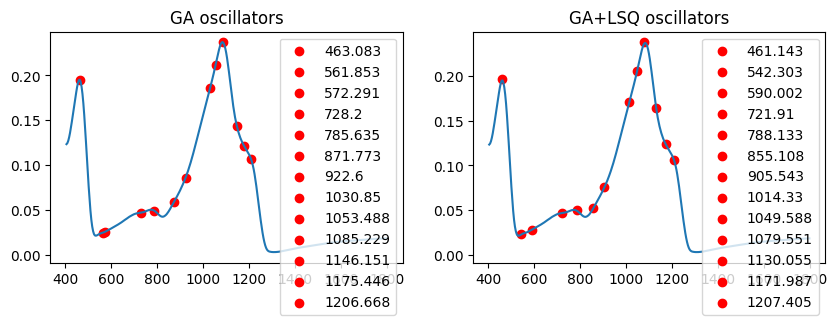

  8%|▊         | 767/10000 [03:45<45:14,  3.40it/s]  


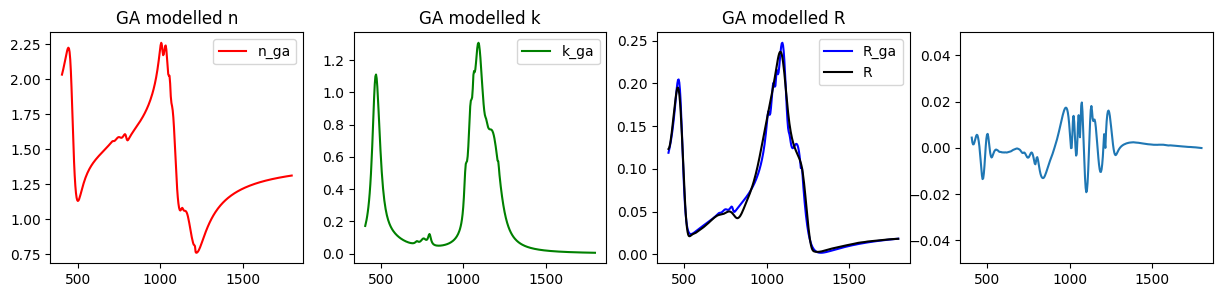

463.19677448738827	552.1615360272245	580.9781476925497	717.6019903426615	758.2464136884738	794.2704064566848	851.550940165422	882.8893019650749	1012.5107285045256	1040.8356193615932	1060.609960906591	1083.4627547214955	1136.2767006812153	1169.843836967558	1211.4138427584726	0.10308014872711424	0.5427576032919137	0.5760260047808918	0.03347572362397244	0.05508014087372359	0.026766288462123367	1.7024842890783387	1.5678419118705604	0.022241300991208135	0.03149379102177874	0.01395895513200407	0.052125583214590376	0.018640125188705836	0.08167540000439932	0.004917816037043776	0.40135341397843494	0.10640281998255996	0.00691056371842147	0.001804212536963723	0.0077023566157132795	0.005830502123285841	0.0005524167933599333	0.000354822372245156	0.02573465354399418	0.07531817467944979	0.013801111969965918	0.18214091919948605	0.003004281761129768	0.09351215864283136	0.00039426852157564696	1.9972837103239647
Fitness value of the best solution = 80.3
Best fitness value reached after 667 generations.
C

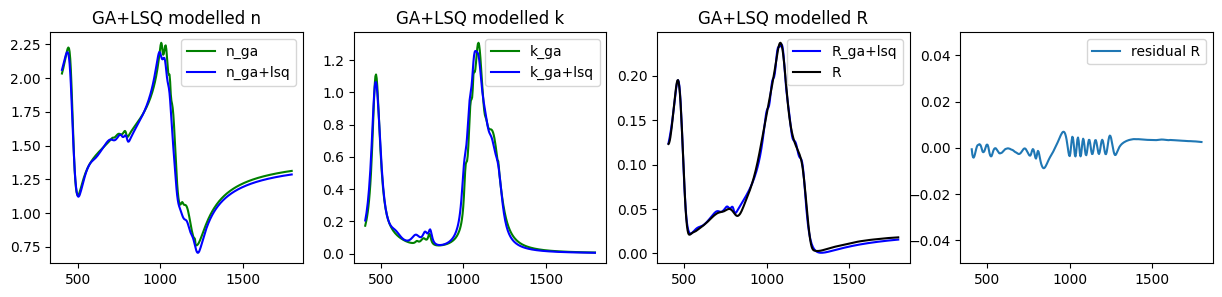

Chi-square goodness of fitness is  0.181
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.01
Chi-square goodness of R3 fitness is  0.02
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.143


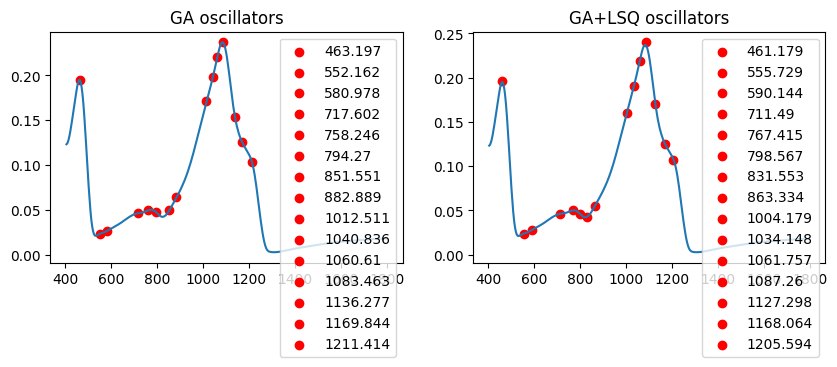

 11%|█         | 1059/10000 [09:33<1:20:40,  1.85it/s]


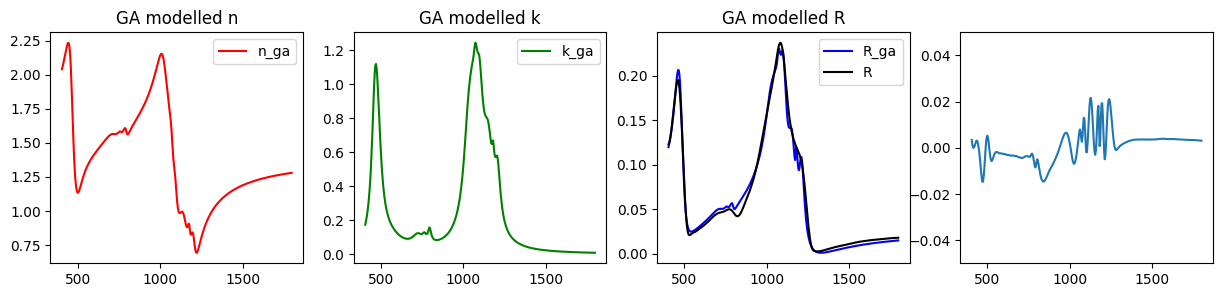

462.55363713994143	542.2373273374375	571.4889159139807	723.4661155262728	763.3774199935717	794.7933418101707	860.2702103524095	889.0437868483739	926.619467697431	1023.5672294504477	1050.8224180830152	1070.5271667716313	1093.414467915009	1144.9264081636754	1177.786898327164	1202.6836728228764	0.10439005663094947	0.3466483260303308	0.40208617899883126	0.10927706347416	0.03704941190639244	0.02854095693375669	1.9890180234879542	1.9749565129846007	1.9698733979495557	0.058610338767908665	0.09047198719687954	0.023020515227490934	0.02924808795375844	0.052443041000106216	0.013267094137123348	0.02784979005464927	0.41364289812158206	0.04399573341318397	0.03281824500858077	0.02133460104261209	0.0041406417187728195	0.007115997361569537	0.004738011600728731	0.0061388133069761874	0.006141502114372477	0.06499250778385579	0.2732470241837084	0.014831361243200725	0.020589007058338105	0.038072288248958364	0.0037303110961823815	0.012126433293900618	1.9151842170360587
Fitness value of the best solution = 66

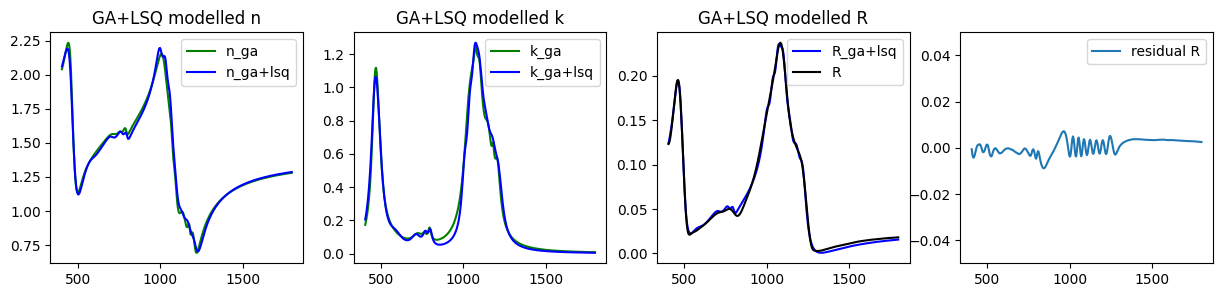

Chi-square goodness of fitness is  0.179
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.01
Chi-square goodness of R3 fitness is  0.021
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.142


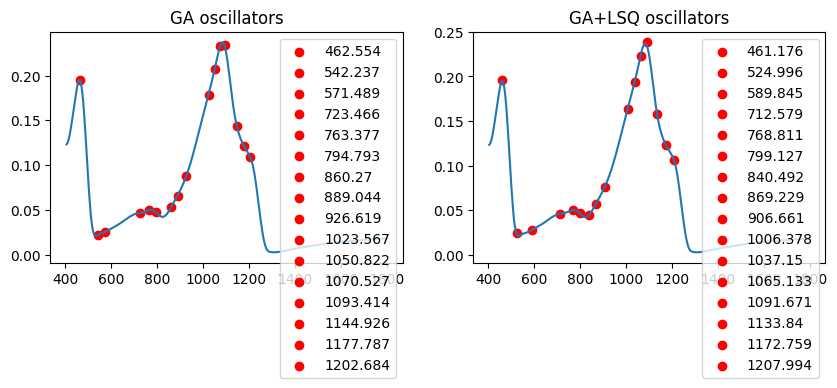

 10%|▉         | 998/10000 [08:14<1:14:16,  2.02it/s]


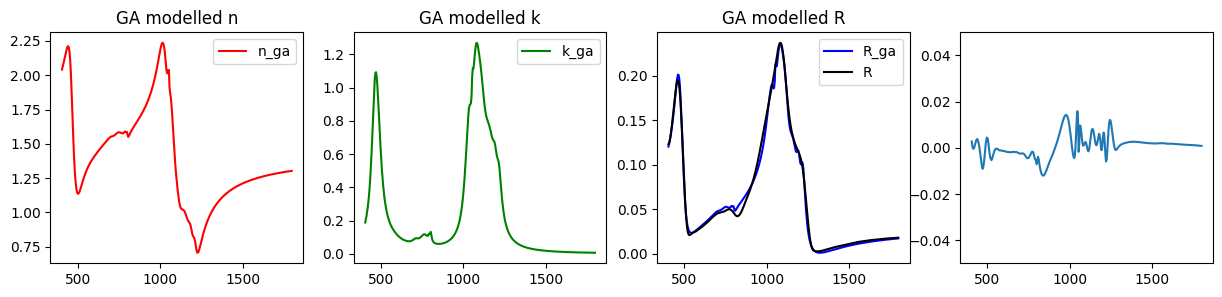

462.310057809821	532.6747988423872	579.3291956279871	709.7436651316822	763.2725932513436	790.0951919993233	801.9110268009141	860.8001194311119	869.7361392392447	930.7907298842124	1022.484958227486	1033.4239557281817	1053.9563375876817	1071.0857551919255	1102.9655734157188	1153.7474748503953	1187.672071923691	1212.6103173173128	0.10867866133137039	0.5289672584847971	0.10888905138411964	0.06767227497646688	0.08087223564989188	0.014857938061235698	0.016056829970952036	1.8987874231650748	1.803311550113965	1.8337688114503212	0.04948482115708108	0.02963357766118402	0.0072865297139934615	0.054701204063102526	0.04990312793355489	0.07042084538858595	0.027899354965817524	0.02565987102844902	0.4130026761852532	0.10825173477944583	0.0009672106304654537	0.005362953667213288	0.017196730450373066	0.001110421695564856	0.0028230527276877915	0.000550703659697227	0.0008330339850344259	0.004810129386740192	0.07029983377667293	0.02910980897101445	0.005099190026239819	0.179958094749336	0.035100850717054266	

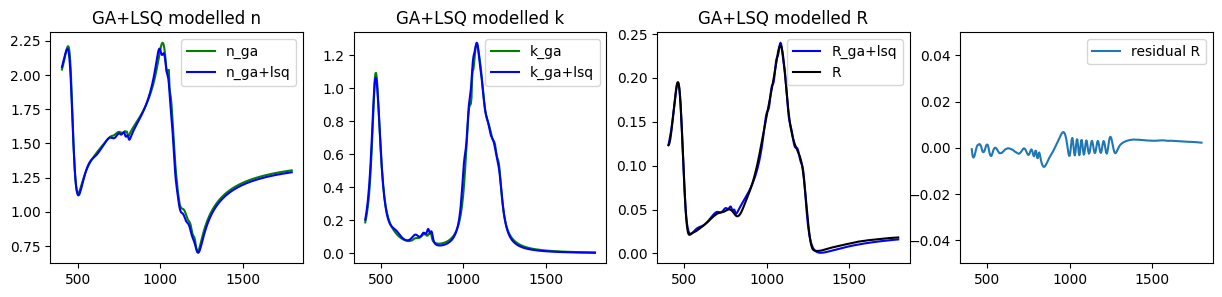

Chi-square goodness of fitness is  0.158
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.009
Chi-square goodness of R3 fitness is  0.018
Chi-square goodness of R4 fitness is  0.001
Chi-square goodness of R5 fitness is  0.003
Chi-square goodness of R6 fitness is  0.125


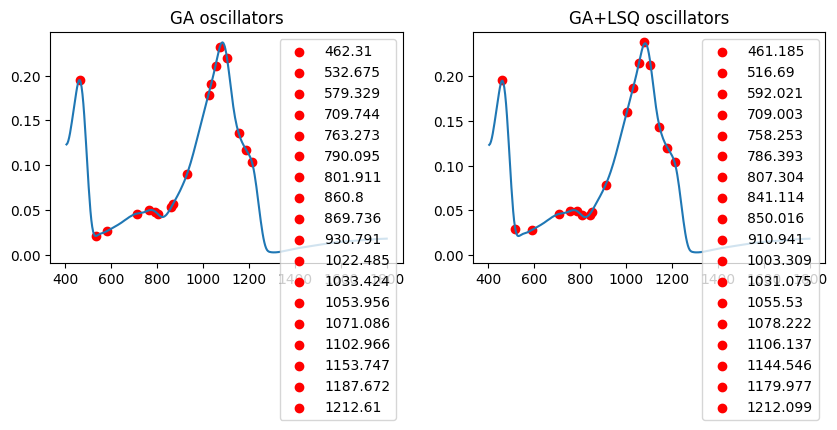

In [11]:
def count(sett, rangee):
    c=0   
    for val in sett:
        if  rangee[0] < val < rangee[-1]:
            c+=1       
    return c


ga_R_mod = {}
ga_R_res = {}
ga_n = {}
ga_k = {}


ga_lsq_R_mod = {}
ga_lsq_R_res = {}
ga_lsq_n = {}
ga_lsq_k = {}

lst_folders = ['best_solution_fitness', 'optical_constants', 'oscillation_params']

for lf in lst_folders:
    if os.path.isdir(lf):
        shutil.rmtree(lf)
        os.mkdir(lf)
    else:
        os.mkdir(lf)
        

max_num_oscillators_R1 = 1
max_num_oscillators_R2 = 5
max_num_oscillators_R3 = 5
max_num_oscillators_R4 = 1 
max_num_oscillators_R5 = 5 
max_num_oscillators_R6 = 0 

osc2 = 1
num_oscillators =2 
total_num_oscillators = max_num_oscillators_R1 + max_num_oscillators_R2 + max_num_oscillators_R3 + max_num_oscillators_R4 + max_num_oscillators_R5 + max_num_oscillators_R6


run = 1

while num_oscillators < total_num_oscillators:    
    if osc2 == 1:
        lb_ga_nu = np.repeat(420,num_oscillators)
        ub_ga_nu = np.repeat(1300,num_oscillators)
        osc2 = 0
        
    else:
        lb_ga_nu = ga_solution[:num_oscillators]-10.
        ub_ga_nu = ga_solution[:num_oscillators]+10.

        if chisq_val_R1 >= 0.03:
            lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R1']][0]+10)
            ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R1']][-1]-10)      

        if chisq_val_R2 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R2']]) < max_num_oscillators_R2:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R2']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R2']][-1]-10)      

        if chisq_val_R3 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R3']]) < max_num_oscillators_R3:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R3']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R3']][-1]-10)
            
        if chisq_val_R4 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R4']]) < max_num_oscillators_R4:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R4']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R4']][-1]-10)      

        if chisq_val_R5 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R5']]) < max_num_oscillators_R5:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R5']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R5']][-1]-10)  
            
#         if chisq_val_R6 >= 0.05:
#             if count(ga_solution[:num_oscillators], v[spectra_range['R6']]) < max_num_oscillators_R6:
#                 lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R6']][0]+10)
#                 ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R6']][-1]-50) 

    
    num_oscillators = len(lb_ga_nu)
    
    lb_ga_nu = np.sort(lb_ga_nu)
    ub_ga_nu = np.sort(ub_ga_nu)

    lb_ga_gamm = np.repeat(0, num_oscillators)
    ub_ga_gamm = np.repeat(2, num_oscillators)

    lb_ga_fourpr = np.repeat(0, num_oscillators)
    ub_ga_fourpr = np.repeat(2, num_oscillators)

    lb_ga = np.hstack((lb_ga_nu, lb_ga_gamm, lb_ga_fourpr)) #lower bound of genes representing gamm, fourpr
    ub_ga = np.hstack((ub_ga_nu, ub_ga_gamm, ub_ga_fourpr)) #upper bound of genes representing gamm, fourpr

    gene_space = []
    for i in np.arange(len(lb_ga)):
        gene_space.append({'low': lb_ga[i], 'high': ub_ga[i]})
    gene_space.append({'low':1, 'high':4})


    ga_instance = ga_optical_constants(gene_space)
    ga_solution, ga_solution_fitness, ga_solution_idx = ga_instance.best_solution()
#     ga_instance.plot_fitness()

    R_ga,n_ga,k_ga = calculate_rnk(ga_solution, v, viewing_angle)


    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].plot(v,n_ga,'r', label='n_ga')
    ax[0].legend(bbox_to_anchor=(1,1))
    ax[0].set_title('GA modelled n')

    ax[1].plot(v,k_ga,'g', label='k_ga')
    ax[1].legend(bbox_to_anchor=(1,1))
    ax[1].set_title('GA modelled k')

    ax[2].plot(v,R_ga,'b', label='R_ga')
    ax[2].plot(v,R_smoothed,'k', label='R')
    ax[2].legend(bbox_to_anchor=(1,1))
    ax[2].set_title('GA modelled R')  

    ax[3].plot(v, R_smoothed-R_ga, label='residual R')
    ax[3].set_ylim(-0.05, +0.05)
    plt.show()

    print("\t".join(map(str, ga_solution)))
    

    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=ga_solution_fitness))

    if ga_instance.best_solution_generation != -1:
        print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

    chisq_val = chisq(R_ga, R_smoothed)
    print("Chi-square goodness of overall fitness is ", chisq_val)

    chisq_val_R1 = chisq(R_ga[spectra_range['R1']], R_smoothed[spectra_range['R1']])
    chisq_val_R2 = chisq(R_ga[spectra_range['R2']], R_smoothed[spectra_range['R2']])
    chisq_val_R3 = chisq(R_ga[spectra_range['R3']], R_smoothed[spectra_range['R3']])
    chisq_val_R4 = chisq(R_ga[spectra_range['R4']], R_smoothed[spectra_range['R4']])
    chisq_val_R5 = chisq(R_ga[spectra_range['R5']], R_smoothed[spectra_range['R5']])
    chisq_val_R6 = chisq(R_ga[spectra_range['R6']], R_smoothed[spectra_range['R6']])
    
    print("Chi-square goodness of R1 fitness is ", chisq_val_R1)
    print("Chi-square goodness of R2 fitness is ", chisq_val_R2)
    print("Chi-square goodness of R3 fitness is ", chisq_val_R3)
    print("Chi-square goodness of R4 fitness is ", chisq_val_R4)
    print("Chi-square goodness of R5 fitness is ", chisq_val_R5)
    print("Chi-square goodness of R6 fitness is ", chisq_val_R6)
    

#     np.savetxt('oscillation_parameters_new.txt', ga_solution)
    np.savetxt('oscillation_params/run%s_%s_NumOfOscillators_ga_oscillation_parameters.txt'%(run, num_oscillators), ga_solution)
    np.savetxt("oscillation_params/run%s_%s_NumOfOscillators_ga_chi_sq.txt"%(run, num_oscillators), np.stack((chisq_val, chisq_val_R1, chisq_val_R2, chisq_val_R3, chisq_val_R4, chisq_val_R5, chisq_val_R6)), header="overall_chisq, R1_chisq, R2_chisq, R3_chisq, R4_chisq, R5_chisq, R6_chisq")
    np.savetxt("optical_constants/run%s_%s_NumOfOscillators_ga_optical_constants.txt"%(run, num_oscillators), np.stack((v, R_ga, R_smoothed-R_ga, n_ga, k_ga), axis=1), header="wavenumber, R_modelled, R_residuals, n , k")
    np.savetxt('best_solution_fitness/run%s_%s_NumOfOscillators_ga_best_solution_fitness_per_generation.txt'%(run, num_oscillators), ga_instance.best_solutions_fitness)
    
    
    
    ga_oscillation_parameters = np.copy(ga_solution)

    N = int((len(ga_oscillation_parameters)-1)/3)

    nu=ga_oscillation_parameters[0:N]
    gamm=ga_oscillation_parameters[N:N+N]
    fourpr=ga_oscillation_parameters[N+N:N+N+N]
    epsil=ga_oscillation_parameters[N+N+N] 

    ga_oscillators_initial = np.hstack((nu,gamm,fourpr,epsil))

    # gamm=gamm./nu;
    # fourpr=Sk./(nu.^2);

    # Set lower and upper bounds
    lb_nu=-20.+nu
    ub_nu=20.+nu
    lb_gamm=np.zeros((1,len(nu)))
    ub_gamm=np.tile(4,(1,len(nu)))
    lb_fourpr=np.zeros((1,len(nu)))
    ub_fourpr=np.tile(4,(1,len(nu)))


    lb=np.hstack((lb_nu,lb_gamm.flatten(),lb_fourpr.flatten(),1))
    ub=np.hstack((ub_nu,ub_gamm.flatten(),ub_fourpr.flatten(),4))

    ga_oscillators_final, lsq_cov = curve_fit(func_lsq_R, xdata=v, p0=ga_oscillators_initial, ydata=R_smoothed, bounds=(lb,ub), maxfev=10000)

    R_final, n_final, k_final = calculate_rnk(ga_oscillators_final,v, viewing_angle)
    
    N = int((len(ga_oscillators_final)-1)/3)

    nu=ga_oscillators_final[0:N]
    gamm=ga_oscillators_final[N:N+N]
    fourpr=ga_oscillators_final[N+N:N+N+N]
    epsil=ga_oscillators_final[N+N+N] 
    

    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].plot(v, n_ga, 'g', label='n_ga')
    ax[0].plot(v, n_final, 'b', label='n_ga+lsq')
    ax[0].legend(bbox_to_anchor=(1,1))
    ax[0].set_title('GA+LSQ modelled n')

    ax[1].plot(v,k_ga,'g', label='k_ga')
    ax[1].plot(v,k_final,'b', label='k_ga+lsq')
    ax[1].legend(bbox_to_anchor=(1,1))
    ax[1].set_title('GA+LSQ modelled k')

    ax[2].plot(v,R_final,'b', label='R_ga+lsq')
    ax[2].plot(v,R_smoothed,'k', label='R')
    ax[2].legend(bbox_to_anchor=(1,1))
    ax[2].set_title('GA+LSQ modelled R')  

    ax[3].plot(v, R_smoothed-R_final, label='residual R')
    ax[3].set_ylim(-0.05, +0.05)
    plt.legend()
    plt.show()

    chisq_val = chisq(R_final[1:], R_smoothed[1:])

    print("Chi-square goodness of fitness is ", chisq_val)

    chisq_val_R1 = chisq(R_final[spectra_range['R1']], R_smoothed[spectra_range['R1']])
    chisq_val_R2 = chisq(R_final[spectra_range['R2']], R_smoothed[spectra_range['R2']])
    chisq_val_R3 = chisq(R_final[spectra_range['R3']], R_smoothed[spectra_range['R3']])
    chisq_val_R4 = chisq(R_final[spectra_range['R4']], R_smoothed[spectra_range['R4']])
    chisq_val_R5 = chisq(R_final[spectra_range['R5']], R_smoothed[spectra_range['R5']])
    chisq_val_R6 = chisq(R_final[spectra_range['R6']], R_smoothed[spectra_range['R6']])
    
    print("Chi-square goodness of R1 fitness is ", chisq_val_R1)
    print("Chi-square goodness of R2 fitness is ", chisq_val_R2)
    print("Chi-square goodness of R3 fitness is ", chisq_val_R3)
    print("Chi-square goodness of R4 fitness is ", chisq_val_R4)
    print("Chi-square goodness of R5 fitness is ", chisq_val_R5)
    print("Chi-square goodness of R6 fitness is ", chisq_val_R6)
    
    
    fig, ax2 = plt.subplots(1,2, figsize=(10, 3))

    ax2[0].plot(v,R_smoothed)
    for i in ga_solution[:num_oscillators]:
        ax2[0].scatter(i, R_smoothed[np.abs(v-i).argmin()], label=round(i,3), color='r')
    ax2[0].legend()
    ax2[0].set_title("GA oscillators")

    ax2[1].plot(v,R_smoothed)
    for i in ga_oscillators_final[:num_oscillators]:
        ax2[1].scatter(i, R[np.abs(v-i).argmin()], label=round(i,3), color='r')
    ax2[1].legend()
    ax2[1].set_title("GA+LSQ oscillators")
    plt.show()

    

    R_residuals = R_smoothed-R_final
    
    np.savetxt('oscillation_params/run%s_%s_NumOfOscillators_lsq_oscillation_parameters.txt'%(run, num_oscillators), ga_oscillators_final)
    np.savetxt("optical_constants/run%s_%s_NumOfOscillators_lsq_optical_constants.txt"%(run, num_oscillators), np.stack((v, R_final, R_residuals, n_final, k_final), axis=1), header="wavenumber, R_modelled, R_residuals, n , k")
    np.savetxt("oscillation_params/run%s_%s_NumOfOscillators_lsq_chi_sq.txt"%(run, num_oscillators), np.stack((chisq_val, chisq_val_R1, chisq_val_R2, chisq_val_R3, chisq_val_R4, chisq_val_R5, chisq_val_R6)), header="overall_chisq, R1_chisq, R2_chisq, R3_chisq, R4_chisq, R5_chisq, R6_chisq")
    
    run+=1
    
    if (N>=total_num_oscillators) or (run>=total_num_oscillators):
        break


